<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


####**Read data**
Here we consider different combinations of attributes as the quasi-identifiers:

*   All attributes
*   Voting age * race
*   Race (compared with NHGIS)




Franklin county

In [3]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
from lib.uniques import *

filename_hist1 = 'data/franklin/microdata/franklin_hist.csv'
hist1 = pd.read_csv(filename_hist1)
filename_hist2 = 'data/franklin/microdata/rho_1.60/franklin_hist_dp_blk.csv'
hist2 = pd.read_csv(filename_hist2)

n2, n3, n4 = 2, 2, 63

## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)
hist1_detail = query_detail_ori(hist1)
hist2_detail = query_detail_dp(hist2)

## QID 2: VA * RACE (126 cells)
hist1_va_race = query_race_va_ori(n2, n4, hist1)
hist2_va_race = query_race_va_dp(n2, n4, hist2)

## QID 3: Race* (7 cells)
hist1_race = query_race_ori(n4, hist1)
hist2_race = query_race_dp(n4, hist2)

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Guernsey county

In [25]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
from lib.uniques import *

filename_hist1_g = 'data/guernsey/microdata/guernsey_hist.csv'
hist1_g = pd.read_csv(filename_hist1_g)
filename_hist2_g = 'data/guernsey/microdata/rho_1.60/guernsey_hist_dp_blk2.csv'
hist2_g = pd.read_csv(filename_hist2_g)

n2, n4 = 2, 63

## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE  (2016 cells)
hist1_detail_g = query_detail_ori(hist1_g)
hist2_detail_g = query_detail_dp(hist2_g)

## QID 2: VA * RACE (126 cells)
hist1_va_race_g = query_race_va_ori(n2, n4, hist1_g)
hist2_va_race_g = query_race_va_dp(n2, n4, hist2_g)

## QID 3: Race (7 cells)
hist1_race_g = query_race_ori(n4, hist1_g)
hist2_race_g = query_race_dp(n4, hist2_g)

/content/gdrive/My Drive/Colab Notebooks/census_privacy


####**Impact of geographic scales**
> Some simulations to demonstrate how geographic scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.



#####**Impact of resolutions (aggregation levels)**
> We test the probability of finding a true unique at block, block group, and tract levels. We make comparisons among (1) our results, (2) NHGIS data from the 2021-06-08 vintage of the PPMF, and (3) the OLS estimators.



Group 1: Franklin County, my data

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
from lib.uniques import *

## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE  (2016 cells)
tpr_detail_blk, tpr_detail_bg, tpr_detail_tr = tpr_res(hist1_detail, hist2_detail)

## QID 2: VA * RACE (126 cells)
tpr_va_race_blk, tpr_va_race_bg, tpr_va_race_tr = tpr_res(hist1_va_race, hist2_va_race) 

## QID 3: Race (7 cells)
tpr_race_blk, tpr_race_bg, tpr_race_tr = tpr_res(hist1_race, hist2_race)

print(tpr_detail_blk, tpr_detail_bg, tpr_detail_tr)
print(tpr_va_race_blk, tpr_va_race_bg, tpr_va_race_tr)
print(tpr_race_blk, tpr_race_bg, tpr_race_tr)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.05789570214587027 0.12453531598513011 0.09016393442622951
0.06246711268135007 0.14803625377643503 0.10452961672473868
0.06568958245466049 0.13142857142857142 0.15384615384615385


Group 2: Franklin County, OLS

> Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

> $p(TU)=\frac{p(W=0)p(A_1)}{\sum_ip(W=1-i)p(A_i)}$


> $p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
from lib.topdown_ols import *
from lib.uniques import *
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)

## QID 1:  HHGQ ∗ VA ∗ HISP ∗ RACE  (2016 cells)
W_detail = workload_mtx_detail()
tpr_detail_ols_blk, tpr_detail_ols_bg, tpr_detail_ols_tr = tpr_res_ols(rho, hist1_detail, W_detail)

## QID 2: VA * RACE (126 cells)
W_va_race = workload_mtx_va_race()
tpr_va_race_ols_blk, tpr_va_race_ols_bg, tpr_va_race_ols_tr = tpr_res_ols(rho, hist1_va_race, W_va_race)

## QID 3: Race (7 cells)
W_race = workload_mtx_race()
tpr_race_ols_blk, tpr_race_ols_bg, tpr_race_ols_tr = tpr_res_ols(rho, hist1_race, W_race)

print(tpr_detail_ols_blk, tpr_detail_ols_bg, tpr_detail_ols_tr)
print(tpr_va_race_ols_blk, tpr_va_race_ols_bg, tpr_va_race_ols_tr)
print(tpr_race_ols_blk, tpr_race_ols_bg, tpr_race_ols_tr)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016

Group 3: Guernsey County, my data

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
from lib.uniques import *

## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE  (2016 cells)
tpr_detail_blk_g, tpr_detail_bg_g, tpr_detail_tr_g = tpr_res(hist1_detail_g, hist2_detail_g)

## QID 2: VA * RACE (126 cells)
tpr_va_race_blk_g, tpr_va_race_bg_g, tpr_va_race_tr_g = tpr_res(hist1_va_race_g, hist2_va_race_g) 

## QID 3: Race (7 cells)
tpr_race_blk_g, tpr_race_bg_g, tpr_race_tr_g = tpr_res(hist1_race_g, hist2_race_g)

print(tpr_detail_blk_g, tpr_detail_bg_g, tpr_detail_tr_g)
print(tpr_va_race_blk_g, tpr_va_race_bg_g, tpr_va_race_tr_g)
print(tpr_race_blk_g, tpr_race_bg_g, tpr_race_tr_g)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.023809523809523808 0.10204081632653061 0.03125
0.02617801047120419 0.13513513513513514 0.058823529411764705
0.02158273381294964 0.2857142857142857 0


Group 4: Guernsey County, OLS

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
from lib.topdown_ols import *
from lib.uniques import *
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)

## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE  (2016 cells)
W_detail = workload_mtx_detail()
tpr_detail_ols_blk_g, tpr_detail_ols_bg_g, tpr_detail_ols_tr_g = tpr_res_ols(rho, hist1_detail_g, W_detail)

## QID 2: VA * RACE (126 cells)
W_va_race = workload_mtx_va_race()
tpr_va_race_ols_blk_g, tpr_va_race_ols_bg_g, tpr_va_race_ols_tr_g = tpr_res_ols(rho, hist1_va_race_g, W_va_race)

## QID 3: Race (7 cells)
W_race = workload_mtx_race()
tpr_race_ols_blk_g, tpr_race_ols_bg_g, tpr_race_ols_tr_g = tpr_res_ols(rho, hist1_race_g, W_race)

print(tpr_detail_ols_blk_g, tpr_detail_ols_bg_g, tpr_detail_ols_tr_g)
print(tpr_va_race_ols_blk_g, tpr_va_race_ols_bg_g, tpr_va_race_ols_tr_g)
print(tpr_race_ols_blk_g, tpr_race_ols_bg_g, tpr_race_ols_tr_g)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016

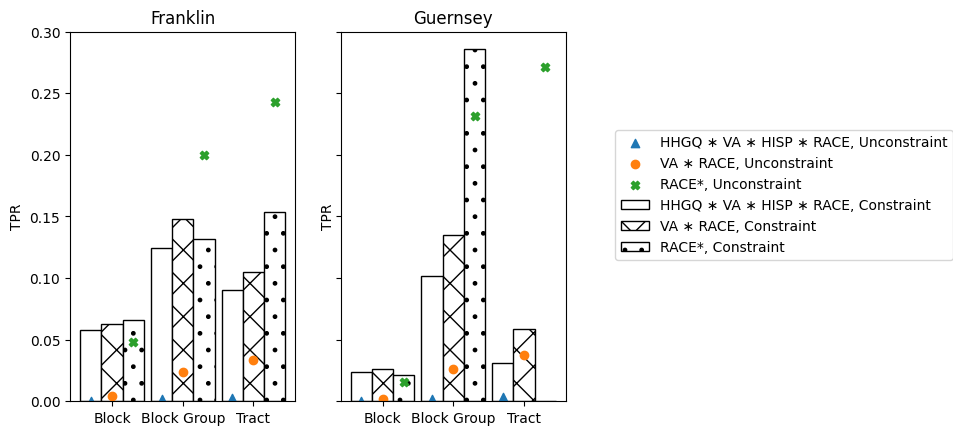

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style

# style.use('seaborn-white')

labels = ['Block', 'Block Group', 'Tract']
x = np.arange(len(labels))  # the label locations
width = 0.3 # the width of the bars
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

## franklin
## Constraint
tpr_1 = [tpr_detail_blk, tpr_detail_bg, tpr_detail_tr]
tpr_2 = [tpr_va_race_blk, tpr_va_race_bg, tpr_va_race_tr]
tpr_3 = [tpr_race_blk, tpr_race_bg, tpr_race_tr]

rects1 = ax[0].bar(x - width, tpr_1, width, label='HHGQ ∗ VA ∗ HISP ∗ RACE, Constraint', color='white', edgecolor='black')
rects2 = ax[0].bar(x, tpr_2, width, label='VA ∗ RACE, Constraint', color='white', edgecolor='black', hatch="x")
rects3 = ax[0].bar(x + width, tpr_3, width, label='RACE*, Constraint', color='white', edgecolor='black', hatch=".")
ax[0].set_title('Franklin')
ax[0].set_ylabel('TPR')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)

## Unconstraint
tpr_1 = [tpr_detail_ols_blk, tpr_detail_ols_bg, tpr_detail_ols_tr]
tpr_2 = [tpr_va_race_ols_blk, tpr_va_race_ols_bg, tpr_va_race_ols_tr]
tpr_3 = [tpr_race_ols_blk, tpr_race_ols_bg, tpr_race_ols_tr]
ax[0].scatter(x - width, tpr_1, marker='^', zorder=2, label='HHGQ ∗ VA ∗ HISP ∗ RACE, Unconstraint')
ax[0].scatter(x, tpr_2, marker='o', zorder=2, label='VA ∗ RACE, Unconstraint')
ax[0].scatter(x + width, tpr_3, marker='X', zorder=2, label='RACE*, Unconstraint')


## guernsey
## Constraint
tpr_1 = [tpr_detail_blk_g, tpr_detail_bg_g, tpr_detail_tr_g]
tpr_2 = [tpr_va_race_blk_g, tpr_va_race_bg_g, tpr_va_race_tr_g]
tpr_3 = [tpr_race_blk_g, tpr_race_bg_g, tpr_race_tr_g]

rects1 = ax[1].bar(x - width, tpr_1, width, label='HHGQ ∗ VA ∗ HISP ∗ RACE, Constraint', color='white', edgecolor='black')
rects2 = ax[1].bar(x, tpr_2, width, label='VA ∗ RACE, Constraint', color='white', edgecolor='black', hatch="x")
rects3 = ax[1].bar(x + width, tpr_3, width, label='RACE*, Constraint', color='white', edgecolor='black', hatch=".")
ax[1].set_title('Guernsey')
ax[1].set_ylabel('TPR')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

## Unconstraint
tpr_1 = [tpr_detail_ols_blk_g, tpr_detail_ols_bg_g, tpr_detail_ols_tr_g]
tpr_2 = [tpr_va_race_ols_blk_g, tpr_va_race_ols_bg_g, tpr_va_race_ols_tr_g]
tpr_3 = [tpr_race_ols_blk_g, tpr_race_ols_bg_g, tpr_race_ols_tr_g]
ax[1].scatter(x - width, tpr_1, marker='^', zorder=2, label='HHGQ ∗ VA ∗ HISP ∗ RACE, Unconstraint')
ax[1].scatter(x, tpr_2, marker='o', zorder=2, label='VA ∗ RACE, Unconstraint')
ax[1].scatter(x + width, tpr_3, marker='X', zorder=2, label='RACE*, Unconstraint')

lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc=5, bbox_to_anchor=(1.5, 0.5))
# fig.set_figwidth(12)
plt.show()
plt.close()

Group 5*: Franklin County, NHGIS data (2021-06-08)

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

## block
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_blk == hist2_nhgis_blk) & (hist1_nhgis_blk == 1) & (hist2_nhgis_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_blk == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
tpr_race_nhgis_blk = n_tu / n_u # frequency of finding the true uniques

## block group
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_blck_grp.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
hist1_nhgis_bg = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_bg = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_bg == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
tpr_race_nhgis_bg = n_tu / n_u # frequency of finding the true uniques

## tract
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_tract.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
hist1_nhgis_tr = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_tr = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_tr == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
tpr_race_nhgis_tr = n_tu / n_u # frequency of finding the true uniques

print(tpr_race_nhgis_blk, tpr_race_nhgis_bg, tpr_race_nhgis_tr)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.115491452991453 0.2316715542521994 0.18181818181818182


Group 6*: Guernsey County, NHGIS data (2021-06-08)

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

## block
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '059')]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_blk == hist2_nhgis_blk) & (hist1_nhgis_blk == 1) & (hist2_nhgis_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_blk == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
tpr_race_nhgis_blk_g = n_tu / n_u # frequency of finding the true uniques

## block group
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_blck_grp.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '059')]
hist1_nhgis_bg = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_bg = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_bg == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
tpr_race_nhgis_bg_g = n_tu / n_u # frequency of finding the true uniques

## tract
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_tract.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '059')]
hist1_nhgis_tr = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_tr = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_tr == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
tpr_race_nhgis_tr_g = n_tu / n_u # frequency of finding the true uniques

print(tpr_race_nhgis_blk_g, tpr_race_nhgis_bg_g, tpr_race_nhgis_tr_g)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.05701078582434515 0.3448275862068966 0.5


#####**Impact of extents**

Read block and tract data

In [ ]:
!pip install geopandas
!pip install pysal

Franklin county

In [62]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'data/franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block['GEOID10'] = data_block['GEOID10'].astype(str)
data_block['BGID10'] = data_block['GEOID10'].str[:12]
data_block['TRACTID10'] = data_block['GEOID10'].str[:11]

filename_tract = 'data/franklin/buildings/franklin_tract10.json'
data_tract = gpd.read_file(filename_tract)
data_tract['GEOID10'] = data_tract['GEOID10'].astype(str)
data_block.columns, data_tract.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


(Index(['OBJECTID_1', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
        'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
        'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'PUMA',
        'Shape_Length', 'Shape_Area', 'BGID10', 'TRACTID10', 'geometry'],
       dtype='object'),
 Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
        'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
        'INTPTLAT10', 'INTPTLON10', 'Shape_Length', 'Shape_Area', 'geometry'],
       dtype='object'))

Guernsey county

In [59]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block_g = 'data/guernsey/buildings/guernsey_block10.json'
data_block_g = gpd.read_file(filename_block_g)
data_block_g['GEOID10'] = data_block_g['GEOID10'].astype(str)
data_block_g['BGID10'] = data_block_g['GEOID10'].str[:12]
data_block_g['TRACTID10'] = data_block_g['GEOID10'].str[:11]

filename_tract_g = 'data/guernsey/buildings/guernsey_tract10.json'
data_tract_g = gpd.read_file(filename_tract_g)
data_tract_g['GEOID10'] = data_tract_g['GEOID10'].astype(str)
data_block_g.columns, data_tract_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


(Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
        'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'FUNCSTAT10', 'ALAND10',
        'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'BGID10',
        'TRACTID10'],
       dtype='object'),
 Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
        'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
        'INTPTLAT10', 'INTPTLON10', 'geometry'],
       dtype='object'))

######**Continuous neighbors**

> Find blocks in the most populated tract (largest population density), and keep searching the neighbors based on Rook continuity until all blocks in the county are covered.



**Franklin county**

In [58]:
col_names = hist1_race.columns.to_numpy()
hist1_tr = hist1_race.groupby(hist1_race.index.astype(str).str[:11]).sum()
hist1_tr.index.name = 'TRACT'
total = hist1_tr.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])

data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(232, '39049001810')

Group 1: Franklin County, my data

In [11]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
tpr_detail, tpr_va_race, tpr_race = [], [], []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1
    tract_ids = data_tract["GEOID10"].iloc[tract_index]

    ## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)
    hist1_sub = hist1_detail[hist1_detail.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_detail[hist2_detail.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_all = n_tu / n_u   # frequency of finding the true uniques
    tpr_detail.append(tpr_all)

    ## QID 2: VA * RACE (126 cells)
    hist1_sub = hist1_va_race[hist1_va_race.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_va_race[hist2_va_race.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_all = n_tu / n_u   # frequency of finding the true uniques
    tpr_va_race.append(tpr_all)

    ## QID 3: Race* (7 cells)
    hist1_sub = hist1_race[hist1_race.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_race[hist2_race.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_all = n_tu / n_u   # frequency of finding the true uniques
    tpr_race.append(tpr_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
tpr_detail, tpr_va_race, tpr_race

([0.09523809523809523,
  0.03205128205128205,
  0.074719800747198,
  0.06976744186046512,
  0.06495882891125343,
  0.06116378509016546,
  0.059516351334419244,
  0.058758417120191864,
  0.05805600351854567,
  0.05897840968931016,
  0.057896369841762337,
  0.05789570214587027],
 [0.07692307692307693,
  0.04032258064516129,
  0.07333333333333333,
  0.06752655538694992,
  0.06583427922814983,
  0.0664215122960239,
  0.0651601919207553,
  0.06376878082348893,
  0.06294213676764013,
  0.06413069982930993,
  0.06262888566409532,
  0.06246711268135007],
 [0.09090909090909091,
  0.037037037037037035,
  0.08430913348946135,
  0.08067729083665338,
  0.07761642463695544,
  0.07682659140796488,
  0.07269617276031644,
  0.06855032910579548,
  0.06486555371479547,
  0.0670926517571885,
  0.06607410580424074,
  0.06568958245466049])

Group 2: Franklin County, OLS

In [14]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
tpr_detail_ols, tpr_va_race_ols, tpr_race_ols = [], [], []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1
    tract_ids = data_tract["GEOID10"].iloc[tract_index]

    ## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)  
    hist1_sub = hist1_detail[hist1_detail.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_detail_ols.append(tpr_all)

    ## QID 2: VA * RACE (126 cells)
    hist1_sub = hist1_va_race[hist1_va_race.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_va_race_ols.append(tpr_all)

    ## QID 3: RACE* (7 cells)
    hist1_sub = hist1_race[hist1_race.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_race_ols.append(tpr_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
tpr_detail_ols, tpr_va_race_ols, tpr_race_ols

(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


([0.0006106621005905862,
  0.0003590292383670816,
  0.000451082296234845,
  0.0003813985484260077,
  0.0003632247190565789,
  0.00036633060243307077,
  0.00035988705060959787,
  0.0003690669510830209,
  0.0003670446200987201,
  0.00036372738419787853,
  0.00035801277168568833,
  0.00035672844945430716],
 [0.004400494287651093,
  0.003553499928300122,
  0.005067404777486273,
  0.004518410939235337,
  0.004530737399376788,
  0.004646032603399037,
  0.004598639640657033,
  0.0047051136862980665,
  0.004688897034899499,
  0.004670063115714091,
  0.00459538797759756,
  0.004578081232346899],
 [0.061036521048569777,
  0.03893833551927802,
  0.06625487317389685,
  0.056935698944827716,
  0.0543993054000305,
  0.052735153231142466,
  0.05098011686706259,
  0.05065267007714823,
  0.04960023048297752,
  0.04934832883618581,
  0.04829368738461431,
  0.04810039918421055])

Group 5*: Franklin County, NHGIS data (2021-06-08)

In [47]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
tpr_race_nhgis = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1

    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    hist1_sub = hist1_nhgis_blk[hist1_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    hist2_sub = hist2_nhgis_blk[hist2_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_all = n_tu / n_u   # frequency of finding the true uniques
    tpr_race_nhgis.append(tpr_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
tpr_race_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.2857142857142857,
 0.18032786885245902,
 0.16194331983805668,
 0.15,
 0.13799448022079117,
 0.13467132053519487,
 0.12461820403176542,
 0.1198201092194025,
 0.11827541827541828,
 0.11745886654478976,
 0.1163877417952619,
 0.115491452991453]

**Guernsey county**

In [49]:
col_names = hist1_race_g.columns.to_numpy()
hist1_tr_g = hist1_race_g.groupby(hist1_race_g.index.astype(str).str[:11]).sum()
hist1_tr_g.index.name = 'TRACT'
total = hist1_tr_g.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract_g.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])

data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(8, '39059977500')

Group 3: Guernsey County, my data

In [33]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
tpr_detail_g, tpr_va_race_g, tpr_race_g = [], [], []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]

    ## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)
    hist1_sub = hist1_detail_g[hist1_detail_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_detail_g[hist2_detail_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_detail_g.append(tpr_all)

    ## QID 2: VA * RACE (126 cells)
    hist1_sub = hist1_va_race_g[hist1_va_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_va_race_g[hist2_va_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_va_race_g.append(tpr_all)

    ## QID 3: Race* (7 cells)
    hist1_sub = hist1_race_g[hist1_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_race_g[hist2_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_race_g.append(tpr_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
tpr_detail_g, tpr_va_race_g, tpr_race_g

([0, 0.02702702702702703, 0.023809523809523808, 0.023809523809523808],
 [0, 0.028985507246376812, 0.025806451612903226, 0.02617801047120419],
 [0, 0.02, 0.018018018018018018, 0.02158273381294964])

Group 4: Guernsey County, OLS

In [34]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
tpr_detail_ols_g, tpr_va_race_ols_g, tpr_race_ols_g = [], [], []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]

    ## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)  
    hist1_sub = hist1_detail_g[hist1_detail_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_detail_ols_g.append(tpr_all)

    ## QID 2: VA * RACE (126 cells)
    hist1_sub = hist1_va_race_g[hist1_va_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_va_race_ols_g.append(tpr_all)

    ## QID 3: RACE* (7 cells)
    hist1_sub = hist1_race_g[hist1_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_race_ols_g.append(tpr_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
tpr_detail_ols_g, tpr_va_race_ols_g, tpr_race_ols_g

(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


([0.000276239587996728,
  0.00019289054087146036,
  0.00012397522318016976,
  0.00011277950240181518],
 [0.004081310029560179,
  0.00274335695828831,
  0.0017738922899430414,
  0.0016187476132181087],
 [0.04114738788952455,
  0.02936527458858291,
  0.017444737472524757,
  0.01568221578235666])

Group 6*: Guernsey County, NHGIS data (2021-06-08)

In [54]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
tpr_race_nhgis_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1

    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    hist1_sub = hist1_nhgis_blk[hist1_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    hist2_sub = hist2_nhgis_blk[hist2_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_all = n_tu / n_u   # frequency of finding the true uniques
    tpr_race_nhgis_g.append(tpr_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
tpr_race_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.08823529411764706,
 0.06293706293706294,
 0.05904761904761905,
 0.05701078582434515]

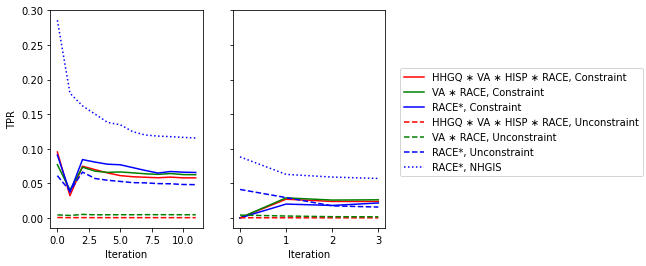

In [56]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].plot(np.array(tpr_detail), color = 'r', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Constraint')
ax[0].plot(np.array(tpr_va_race), color = 'g', label='VA ∗ RACE, Constraint')
ax[0].plot(np.array(tpr_race), color = 'b', label='RACE*, Constraint')
ax[0].plot(np.array(tpr_detail_ols), color = 'r', linestyle='--', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Unconstraint')
ax[0].plot(np.array(tpr_va_race_ols), color = 'g', linestyle='--', label='VA ∗ RACE, Unconstraint')
ax[0].plot(np.array(tpr_race_ols), color = 'b', linestyle='--', label='RACE*, Unconstraint')
ax[0].plot(np.array(tpr_race_nhgis), color = 'b', linestyle=':', label='RACE*, NHGIS')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("TPR")

ax[1].plot(np.array(tpr_detail_g), color = 'r', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Constraint')
ax[1].plot(np.array(tpr_va_race_g), color = 'g', label='VA ∗ RACE, Constraint')
ax[1].plot(np.array(tpr_race_g), color = 'b', label='RACE*, Constraint')
ax[1].plot(np.array(tpr_detail_ols_g), color = 'r', linestyle='--', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Unconstraint')
ax[1].plot(np.array(tpr_va_race_ols_g), color = 'g', linestyle='--', label='VA ∗ RACE, Unconstraint')
ax[1].plot(np.array(tpr_race_ols_g), color = 'b', linestyle='--', label='RACE*, Unconstraint')
ax[1].plot(np.array(tpr_race_nhgis_g), color = 'b', linestyle=':', label='RACE*, NHGIS')
ax[1].set_xlabel("Iteration")

lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc=5, bbox_to_anchor=(1.5, 0.5))

plt.show()

######**Random**

Randomly sample 10% of the blocks (without replacement) and add  to the histogram.

In [69]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['BLOCK'] = data_nhgis["gisjoin"].str.slice(14, 18)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT', 'BLOCK']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

data_block_new = data_block
N = int(0.1 * len(data_block_new))
block_ids_all = []
tpr_detail, tpr_va_race, tpr_race, tpr_detail_ols, tpr_va_race_ols, tpr_race_ols, tpr_race_nhgis = [], [], [], [], [], [], []

while len(block_ids_all) < len(data_block):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    ## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)
    ## Constraint
    hist1_sub = hist1_detail[hist1_detail.index.astype(str).isin(block_ids_all)].sort_index()
    hist2_sub = hist2_detail[hist2_detail.index.astype(str).isin(block_ids_all)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_detail.append(tpr_all)

    ## Unconstraint
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_detail_ols.append(tpr_all)


    ## QID 2: VA * RACE (126 cells)
    ## Constraint
    hist1_sub = hist1_va_race[hist1_va_race.index.astype(str).isin(block_ids_all)].sort_index()
    hist2_sub = hist2_va_race[hist2_va_race.index.astype(str).isin(block_ids_all)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_va_race.append(tpr_all)

    ## Unconstraint
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_va_race_ols.append(tpr_all)


    ## QID 3: Race* (7 cells)
    ## Constraint
    hist1_sub = hist1_race[hist1_race.index.astype(str).isin(block_ids_all)].sort_index()
    hist2_sub = hist2_race[hist2_race.index.astype(str).isin(block_ids_all)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_race.append(tpr_all)

    ## Unconstraint
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_race_ols.append(tpr_all)    

    ## NHGIS
    nhgis_sub = data_nhgis[data_nhgis.index.astype(str).isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_nhgis_all = n_tu / n_u
    tpr_race_nhgis.append(tpr_nhgis_all)

tpr_detail, tpr_va_race, tpr_race, tpr_detail_ols, tpr_va_race_ols, tpr_race_ols, tpr_race_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


([0.05687203791469194,
  0.05377329666972197,
  0.05348460291734198,
  0.05499231950844854,
  0.057275731244645696,
  0.05831710566772574,
  0.05859204197638828,
  0.05810841807477636,
  0.05771976341015705,
  0.05779109589041096,
  0.05789570214587027],
 [0.0631424375917768,
  0.06336707911511061,
  0.06041770263550472,
  0.06208966422809979,
  0.06425461642396037,
  0.06415094339622641,
  0.06401884166577454,
  0.0629567172568859,
  0.06227075691897299,
  0.06233551394841717,
  0.06246711268135007],
 [0.06779661016949153,
  0.06929637526652452,
  0.06596119929453263,
  0.06914893617021277,
  0.06720544449170565,
  0.06645513837475762,
  0.06620627533403393,
  0.06616778259157148,
  0.06605204808028942,
  0.06559797511073613,
  0.06568958245466049],
 [0.000353247575856543,
  0.00035684353532902235,
  0.0003507777245649222,
  0.00035248402624939965,
  0.0003553835359698959,
  0.00035807859940837955,
  0.0003573886645249786,
  0.0003590234717390462,
  0.00035566964855061,
  0.0003567132

In [67]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['BLOCK'] = data_nhgis["gisjoin"].str.slice(14, 18)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT', 'BLOCK']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

data_block_new = data_block_g
N = int(0.1 * len(data_block_new))
block_ids_all = []
tpr_detail_g, tpr_va_race_g, tpr_race_g, tpr_detail_ols_g, tpr_va_race_ols_g, tpr_race_ols_g, tpr_race_nhgis_g = [], [], [], [], [], [], []

while len(block_ids_all) < len(data_block_g):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    ## QID 1: HHGQ ∗ VA ∗ HISP ∗ RACE (2016 cells)
    ## Constraint
    hist1_sub = hist1_detail_g[hist1_detail_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_detail_g[hist2_detail_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_detail_g.append(tpr_all)

    ## Unconstraint
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_detail_ols_g.append(tpr_all)


    ## QID 2: VA * RACE (126 cells)
    ## Constraint
    hist1_sub = hist1_va_race_g[hist1_va_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_va_race_g[hist2_va_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_va_race_g.append(tpr_all)

    ## Unconstraint
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_va_race_ols_g.append(tpr_all)


    ## QID 3: Race* (7 cells)
    ## Constraint
    hist1_sub = hist1_race_g[hist1_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_race_g[hist2_race_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        tpr_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        tpr_all = 0
    tpr_race_g.append(tpr_all)

    ## Unconstraint
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = math.exp(-(i - 1)**2 / (2 * sigma**2))
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = 1
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr_all = p3 * p4 / sum(probs)
    tpr_race_ols_g.append(tpr_all)    

    ## NHGIS
    nhgis_sub = data_nhgis[data_nhgis.index.astype(str).isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    tpr_nhgis_all = n_tu / n_u
    tpr_race_nhgis_g.append(tpr_nhgis_all)

tpr_detail_g, tpr_va_race_g, tpr_race_g, tpr_detail_ols_g, tpr_va_race_ols_g, tpr_race_ols_g, tpr_race_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


([0.05491852745926373,
  0.05868044998479781,
  0.05878775592945469,
  0.057169061449098134,
  0.05777669429546563,
  0.05917580186764109,
  0.05820013898540653,
  0.05770696752553743,
  0.0571331751948492,
  0.05791340508806262,
  0.05789570214587027,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808,
  0.023809523809523808],
 [0.05983545250560957,
  0.06371814092953523,
  0.061746987951807226,
  0.06054907860097781,
  0.06030225946431243,
  0.06222775357809583,
  0.062266367617216704,
  0.06207219878105954,
  0.06149487542704775,
  0.0624812030075188,
  0.06246711268135007,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419,
  0.02617801047120419

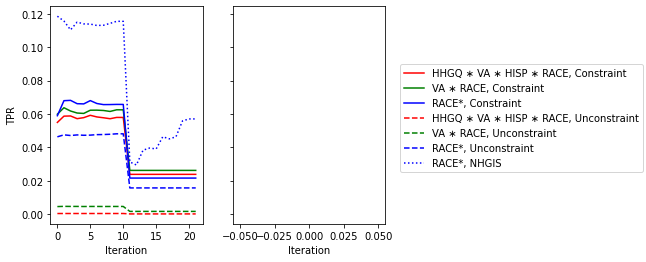

In [68]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].plot(np.array(tpr_detail), color = 'r', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Constraint')
ax[0].plot(np.array(tpr_va_race), color = 'g', label='VA ∗ RACE, Constraint')
ax[0].plot(np.array(tpr_race), color = 'b', label='RACE*, Constraint')
ax[0].plot(np.array(tpr_detail_ols), color = 'r', linestyle='--', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Unconstraint')
ax[0].plot(np.array(tpr_va_race_ols), color = 'g', linestyle='--', label='VA ∗ RACE, Unconstraint')
ax[0].plot(np.array(tpr_race_ols), color = 'b', linestyle='--', label='RACE*, Unconstraint')
ax[0].plot(np.array(tpr_race_nhgis), color = 'b', linestyle=':', label='RACE*, NHGIS')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("TPR")

ax[1].plot(np.array(tpr_detail_g), color = 'r', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Constraint')
ax[1].plot(np.array(tpr_va_race_g), color = 'g', label='VA ∗ RACE, Constraint')
ax[1].plot(np.array(tpr_race_g), color = 'b', label='RACE*, Constraint')
ax[1].plot(np.array(tpr_detail_ols_g), color = 'r', linestyle='--', label='HHGQ ∗ VA ∗ HISP ∗ RACE, Unconstraint')
ax[1].plot(np.array(tpr_va_race_ols_g), color = 'g', linestyle='--', label='VA ∗ RACE, Unconstraint')
ax[1].plot(np.array(tpr_race_ols_g), color = 'b', linestyle='--', label='RACE*, Unconstraint')
ax[1].plot(np.array(tpr_race_nhgis_g), color = 'b', linestyle=':', label='RACE*, NHGIS')
ax[1].set_xlabel("Iteration")

lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc=5, bbox_to_anchor=(1.5, 0.5))

plt.show()

####**More on cell uniqueness**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.

#####**Impact of privacy loss budget (rho)**

For block level data, change epsilon from 1 to 20 while using the same allocation budget.

In [ ]:
import scipy.stats
import math
import numpy as np

delta = 10 ** (-10)
hist1 = pd.crosstab(data_people.GEOID10, data_people.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

tpr_rho = []
for k in np.arange(0.5, 21, 0.5):
    rho = k * 9/4097
    sigma = math.sqrt(1 / (2 * rho))

    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1 == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)

    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1 == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr = p3 * p4 / sum(probs)
    tpr_rho.append(tpr)

tpr_rho

Compare with Guernsey county.

In [ ]:
import scipy.stats
import math
import numpy as np

delta = 10 ** (-10)
hist1 = pd.crosstab(data_people_g.GEOID10, data_people_g.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

tpr_rho_g = []
for k in np.arange(0.5, 21, 0.5):
    rho = k * 9/4097
    sigma = math.sqrt(1 / (2 * rho))

    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1 == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)

    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1 == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    tpr = p3 * p4 / sum(probs)
    tpr_rho_g.append(tpr)

tpr_rho_g

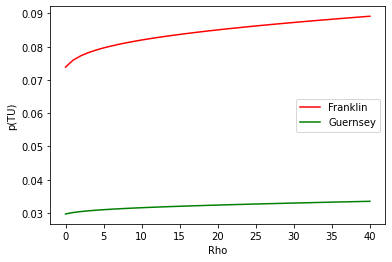

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(tpr_rho), color = 'r', label='Franklin')
plt.plot(np.array(tpr_rho_g), color = 'g', label='Guernsey')
plt.xlabel("Rho")
plt.ylabel("p(TU)")
plt.legend()
plt.show()